## Imports

In [3]:
# Std imports
import operator
from itertools import combinations
# read data
import pandas as pd
# preprocessing
import nltk
from sklearn.feature_extraction.text import CountVectorizer
# LDA model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from gensim.models import KeyedVectors
# Visualization
import matplotlib.pyplot as plt

## Read Data

In [4]:
# filename = "sleep.txt"
filename = "concussion.txt"
# filename = "mental_health.txt"

fp = open(filename, 'r')

data = fp.readlines()

fp.close()

In [5]:
# Converting paragraphs to sentences
sentences = []

for d in data:
    sentence_list = nltk.sent_tokenize(d)
    sentences.extend(sentence_list)

len(sentences)

326

In [6]:
dict = {'text': sentences}

df = pd.DataFrame(dict)
print(df)

                                                  text
0    It’s a late summer day in 1998 during pre-seas...
1    I’m 17 years old, a freshman fullback on the u...
2    After a lackluster start, I’m working to prove...
3    I’ve let nerves shake my confidence and I can ...
4    We’re doing a drill and I’m standing with my b...
..                                                 ...
321  But we are finally easing into each other, sus...
322  We share our secrets, and that impulse to want...
323  We know about the feverish devotion to this th...
324  We know how it turned a young girl without a l...
325  And that what she could never feel in church –...

[326 rows x 1 columns]


## Preprocess Text
### 1. Remove punctuation (,/.!'?")
### 2. Convert to lower case
### 3. Text tokenization
### 4. Remove stop words
### 5. Text leminization
### 6. Bag of words

In [7]:
# remove punctuations
df['processed_text'] = df['text'].str.replace('[^\w\s]','')

print(df['processed_text'])

0      Its a late summer day in 1998 during preseason...
1      Im 17 years old a freshman fullback on the upa...
2      After a lackluster start Im working to prove m...
3      Ive let nerves shake my confidence and I can s...
4      Were doing a drill and Im standing with my bac...
                             ...                        
321    But we are finally easing into each other susp...
322    We share our secrets and that impulse to want ...
323    We know about the feverish devotion to this th...
324    We know how it turned a young girl without a l...
325    And that what she could never feel in church  ...
Name: processed_text, Length: 326, dtype: object


In [8]:
# Remove stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words]))
df.head()

text  \
0  It’s a late summer day in 1998 during pre-seas...   
1  I’m 17 years old, a freshman fullback on the u...   
2  After a lackluster start, I’m working to prove...   
3  I’ve let nerves shake my confidence and I can ...   
4  We’re doing a drill and I’m standing with my b...   

                                      processed_text  
0  late summer day 1998 preseason training womens...  
1  im 17 years old freshman fullback upandcoming ...  
2                  lackluster start im working prove  
3  ive let nerves shake confidence see coach fell...  
4                drill im standing back lanky senior

In [9]:
# from SKLearn docs
# class for tokenizing and lemmatizing
class LemmaTokenizer():
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
        
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in nltk.word_tokenize(doc)]

In [10]:
# this CountVectorizer will put our data in a bag of words w/ word counts
# provided the parameters below, it will also convert words to lower case, tokenize text,
# lemmatize text, stem text, and remove stop words!
vect = CountVectorizer(analyzer='word', 
                       tokenizer=LemmaTokenizer(), 
                       lowercase='True')

x = vect.fit_transform(df['processed_text'])
print('After preprocessing, we have this many words: ' + str(len(vect.get_feature_names())))

After preprocessing, we have this many words: 1660


## Topic Modelling - LDA

### Evaluation (Topic Coherence - TC-W2V)

In [11]:
## Load pretrained Word2Vec model from file
# It is a pretrained Word2Vec model. It w# Retrieve best parameters
best_n_topic = max(hyperparameters_score_dict.items(), key=operator.itemgetter(1))[0]
best_n_topicas trained on Google news dataset. Since the input dataset is an article on # health issues and news usuallly talk about them, the news model would be suitable for the dataset.
# To download the below model, please visit: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [12]:
# http://derekgreene.com/slides/topic-modelling-with-scikitlearn.pdf
def get_mean_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        
        for pair in combinations( term_rankings[topic_index], 2 ):
            try:
                pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            except KeyError:
                continue
        
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # mean coherence across all topics
    mean_coherence = overall_coherence / len(term_rankings)

    return mean_coherence

### Hyperparameters tuning

In [14]:
# Returns the n_top_words words for each topic as a list of list
def get_term_rankings(vect, lda, n_top_words):
    term_rankings = []

    # Appending n_top_words of each topic to term_rankings
    terms = vect.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        top_terms = [terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        term_rankings.append(top_terms)

    return term_rankings

In [15]:
# Function to print the top n_top_words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [17]:
# Grid Search to find best parameters for LDA model
alpha_values = [0.05, 0.1, 0.5]
beta_values = [0.05, 0.1, 0.5]
topic_count = [2, 3, 4, 5, 6, 7, 8, 9]
hyperparameters_score_dict = {}

for ntopic in topic_count:
    for a in alpha_values:
        for b in beta_values:
            print("Topics: ", ntopic, "Alpha: ", a, "Beta: ", b)
            lda = LatentDirichletAllocation(n_components=ntopic, doc_topic_prior=a, topic_word_prior=b)
            lda.fit(x)
            feature_names = vect.get_feature_names()
            term_rankings = get_term_rankings(vect, lda, 10)
            mu_coherence = get_mean_coherence(w2v_model, term_rankings)
            hyperparameters_score_dict[str(ntopic)+","+str(a)+","+str(b)] = round(mu_coherence, 4)
            print(mu_coherence)

Topics:  2 Alpha:  0.05 Beta:  0.05
0.1462694206016345
Topics:  2 Alpha:  0.05 Beta:  0.1
0.16708992365747688
Topics:  2 Alpha:  0.05 Beta:  0.5
0.1641011028136644
Topics:  2 Alpha:  0.1 Beta:  0.05
0.17111735503292747
Topics:  2 Alpha:  0.1 Beta:  0.1
0.16001946596014832
Topics:  2 Alpha:  0.1 Beta:  0.5
0.18773259822693134
Topics:  2 Alpha:  0.5 Beta:  0.05
0.18524607544143995
Topics:  2 Alpha:  0.5 Beta:  0.1
0.15832168165555532
Topics:  2 Alpha:  0.5 Beta:  0.5
0.1504070373588345
Topics:  3 Alpha:  0.05 Beta:  0.05
0.16294109364971518
Topics:  3 Alpha:  0.05 Beta:  0.1
0.16552134149328426
Topics:  3 Alpha:  0.05 Beta:  0.5
0.15193596217367386
Topics:  3 Alpha:  0.1 Beta:  0.05
0.1659587673980881
Topics:  3 Alpha:  0.1 Beta:  0.1
0.17218972604583813
Topics:  3 Alpha:  0.1 Beta:  0.5
0.13513551793854547
Topics:  3 Alpha:  0.5 Beta:  0.05
0.17294065593051966
Topics:  3 Alpha:  0.5 Beta:  0.1
0.15754295385451297
Topics:  3 Alpha:  0.5 Beta:  0.5
0.15793851160797878
Topics:  4 Alpha:  0

In [18]:
# Retrieve best parameters
best_n_topic, best_alpha, best_beta = max(hyperparameters_score_dict.items(), key=operator.itemgetter(1))[0].split(',')
best_n_topic = int(best_n_topic)
best_alpha = float(best_alpha)
best_beta = float(best_beta)

best_n_topic, best_alpha, best_beta

(2, 0.1, 0.5)

In [19]:
# LDA modeling - LDA with best parameters
lda = LatentDirichletAllocation(n_components=best_n_topic, doc_topic_prior=best_alpha, topic_word_prior=best_beta)
lda.fit(x)

LatentDirichletAllocation(doc_topic_prior=0.1, n_components=2,
                          topic_word_prior=0.5)

In [20]:
print("\nTopics in Best LDA model:")
n_top_words = 10
feature_names = vect.get_feature_names()
print_top_words(lda, feature_names, n_top_words)


Topics in Best LDA model:
Topic #0: brain concussion injury year like team player id say played
Topic #1: concussion brain player athlete play time symptom ball field could


## Visualizations

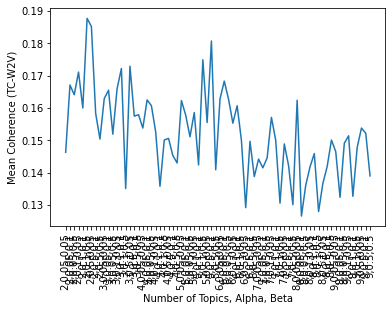

In [21]:
fig, ax = plt.subplots()
ax.plot(list(hyperparameters_score_dict.keys()), list(hyperparameters_score_dict.values()))
plt.xticks(rotation=90)
# fig.autofmt_xdate()
plt.xlabel('Number of Topics, Alpha, Beta')
plt.ylabel('Mean Coherence (TC-W2V)')
fig.show()

In [53]:
fig.savefig("lda_ntopics_alpha_beta_tuning.svg")